In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
import math
# import nltk
# nltk.download("stopwords")
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from scikitplot.metrics import plot_roc


def round_up(n, decimals=2):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

In [2]:
with open('tbird2_1G', 'r', newline='\n') as f2:
    file_content = f2.readlines()[:-1]

In [3]:
### create DataFrame
df = pd.DataFrame(file_content, columns=['raw']) # file_content[-20:]
df['hyp'] = df.raw.apply(lambda x: x.split()[0])
df['id'] = df.raw.apply(lambda x: x.split()[1])
# df['date'] = df.raw.apply(lambda x: x.split()[2])
# df['account'] = df.raw.apply(lambda x: x.split()[3])
# df['log'] = df.raw.apply(lambda x: ' '.join(x.split()[4:]))
df['log'] = df.raw.apply(lambda x: ' '.join(x.split()[2:]))

### target definition
# df['alert_flg'] = df.log.apply(lambda x: 1 if 'ALERT' in x else 0)
# df['fatal_flg'] = df.log.apply(lambda x: 1 if 'FATAL' in x else 0)
# df['failed_flg'] = df.log.apply(lambda x: 1 if 'FAILED' in x else 0)
df['alert_flg'] = df.log.apply(lambda x: 1 if 'alert' in x.lower() else 0)
df['fatal_flg'] = df.log.apply(lambda x: 1 if 'fatal' in x.lower() else 0)
df['failed_flg'] = df.log.apply(lambda x: 1 if 'failed' in x.lower() else 0)
df['target'] = np.where(df['alert_flg']+df['fatal_flg']+df['failed_flg']>0, 1, 0)

df.drop(columns=['raw'], inplace=True)

In [4]:
# drop duplicates
# df.groupby('id').count().sort_values('log', ascending=False)
# df.groupby('log').count().sort_values('id', ascending=False)
df = df.drop_duplicates(subset=['log'])

In [5]:
print(file_content[-1])
print(file_content[-100])
print(file_content[1])
print(file_content[12345])

- 1132502080 2005.11.20 an230 Nov 20 07:54:40 an230/an230 snmpd[1976]: Got trap from peer on fd 13

- 1132502061 2005.11.20 tbird-sm1 Nov 20 07:54:21 src@tbird-sm1 ib_sm.x[24904]: [ib_sm_discovery.c:470]: Failed to GetNodeInfo() because of NO RESPONSE

- 1131524071 2005.11.09 tbird-admin1 Nov 10 00:14:31 local@tbird-admin1 postfix/postdrop[10896]: warning: unable to look up public/pickup: No such file or directory

- 1131569328 2005.11.09 tbird-admin1 Nov 9 12:48:48 local@tbird-admin1 /apps/x86_64/system/ganglia-3.0.1/sbin/gmetad[1682]: data_thread() got not answer from any [Thunderbird_D7] datasource



In [6]:
### class balance
print(df['alert_flg'].sum(), df['fatal_flg'].sum(), df['failed_flg'].sum(), 
      df['alert_flg'].sum() + df['fatal_flg'].sum() + df['failed_flg'].sum(), sep=', ')
df.hyp.value_counts()
df.target.value_counts()

198, 294511, 817472, 1112181


0    4280569
1     960171
Name: target, dtype: int64

In [7]:
# IV. B. 'training set and test set with a ratio of 8:2'

X_train, X_test, y_train, y_test = train_test_split(df[['log']], df.target, test_size=0.2)

In [8]:
### OVERSAMPLING ?????
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
X_train, X_test = X_train.log, X_test.log

df.target.value_counts(), y_train.value_counts(), y_test.value_counts()

(0    4280569
 1     960171
 Name: target, dtype: int64,
 0    3424376
 1    3424376
 Name: target, dtype: int64,
 0    856193
 1    191955
 Name: target, dtype: int64)

#### preprocessing

In [10]:
# tokenize
X_train_tok = X_train.apply(CountVectorizer().build_tokenizer())
X_test_tok = X_test.apply(CountVectorizer().build_tokenizer())

# create lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer() # Mystem()
stopwords_list = stopwords.words('english')

# preprocess function
def preprocess_text(text):
    tokens = [lemmatizer.lemmatize(w.lower()) for w in text 
      if w.lower() not in stopwords_list and w not in punctuation]
    return ' '.join(tokens)

X_train_preproc = X_train_tok.apply(preprocess_text)
print('DONE')
X_test_preproc = X_test_tok.apply(preprocess_text)
print('DONE')

In [11]:
### save datasets
# X_train_preproc.to_csv('X_train_preproc.csv')
# X_test_preproc.to_csv('X_test_preproc.csv')

In [12]:
### no preprocessing option
X_train_preproc = X_train.copy()
X_test_preproc = X_test.copy()

### TF-IDF vectorization
tfidf = TfidfVectorizer(min_df=5, stop_words='english') # max_features=3000
X_train_tfidf = tfidf.fit_transform(X_train_preproc)
X_test_tfidf = tfidf.transform(X_test_preproc)

In [13]:
X_train_tfidf.shape

(6848752, 68792)

### models

In [14]:
models_d = {}

In [24]:
from sklearn.linear_model import LogisticRegression

models_d['LogisticRegression'] = LogisticRegression(max_iter=300)
models_d['LogisticRegression'].fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=300)

In [16]:
from catboost import CatBoostClassifier

models_d['CatBoostClassifier'] = CatBoostClassifier(iterations=30, depth=5, eval_metric='Accuracy') # 200
models_d['CatBoostClassifier'].fit(X_train_tfidf, y_train)

Learning rate set to 0.5
0:	learn: 0.9998642	total: 5.07s	remaining: 2m 27s
1:	learn: 0.9999853	total: 9.86s	remaining: 2m 17s
2:	learn: 0.9999965	total: 13.4s	remaining: 2m 1s
3:	learn: 0.9999980	total: 17.4s	remaining: 1m 52s
4:	learn: 0.9999993	total: 20.8s	remaining: 1m 43s
5:	learn: 0.9999993	total: 24.1s	remaining: 1m 36s
6:	learn: 0.9999993	total: 27.2s	remaining: 1m 29s
7:	learn: 0.9999993	total: 30.3s	remaining: 1m 23s
8:	learn: 0.9999993	total: 32.9s	remaining: 1m 16s
9:	learn: 0.9999993	total: 35.5s	remaining: 1m 11s
10:	learn: 0.9999993	total: 38.8s	remaining: 1m 6s
11:	learn: 0.9999993	total: 41.3s	remaining: 1m 1s
12:	learn: 0.9999993	total: 43.7s	remaining: 57.1s
13:	learn: 0.9999993	total: 46s	remaining: 52.6s
14:	learn: 0.9999993	total: 50s	remaining: 50s
15:	learn: 0.9999993	total: 53.4s	remaining: 46.8s
16:	learn: 0.9999993	total: 55.8s	remaining: 42.7s
17:	learn: 0.9999993	total: 58.6s	remaining: 39.1s
18:	learn: 0.9999993	total: 1m	remaining: 35s
19:	learn: 0.99999

In [17]:
from sklearn.naive_bayes import MultinomialNB

models_d['NaïveBayes'] = MultinomialNB(alpha=0.01) # alpha - Additive smoothing parameter
models_d['NaïveBayes'].fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.01)

In [188]:
### LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GlobalAveragePooling1D, SpatialDropout1D

### preprocessing
max_len = 32
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
print('DONE')

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding='post', truncating='post')
print('DONE')

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding='post', truncating='post')
print('DONE')

DONE
DONE
DONE


In [22]:
### model
embedding_dim = 16

# Define Dense Model Architecture
modelLSTM = Sequential()
modelLSTM.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
modelLSTM.add(SpatialDropout1D(0.5)) # as in paper
modelLSTM.add(LSTM(32, return_sequences=False)) # as in paper
modelLSTM.add(Dropout(0.5)) # as in paper
modelLSTM.add(Dense(1, activation='sigmoid'))


modelLSTM.compile(loss='binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 32, 16)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 32)                6272      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 166,305
Trainable params: 166,305
Non-trainable params: 0
________________________________________________

In [254]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01)
history = modelLSTM.fit(training_padded, y_train, epochs=1, batch_size=256,
                    validation_data=(testing_padded, y_test), callbacks =[early_stop])

26758/26758 [==============================] - 458s 17ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 1.2019e-04 - val_accuracy: 1.0000


In [255]:
# model.evaluate(testing_padded, y_test)
lstm_pred_proba = modelLSTM.predict(testing_padded)
lstm_pred = np.where(lstm_pred_proba.reshape(-1)>0.5, 1, 0)
lstm_train_pred_proba = modelLSTM.predict(training_padded)
lstm_train_pred = np.where(lstm_train_pred_proba.reshape(-1)>0.5, 1, 0)
accuracy_score(y_test, lstm_pred), [x[0] for x in precision_recall_fscore_support(y_test, lstm_pred)]

(0.9999570671317409,
 [0.9999579235751871, 0.9999894805618315, 0.9999737018195418, 855559])

#### Word2Vec embedding

In [299]:
### Word2Vec + LSTM
from gensim.models import Word2Vec

w2v = Word2Vec(sentences=X_train_preproc.apply(lambda x: x.split(' ')), 
               vector_size=embedding_dim, window=5, min_count=10, max_vocab_size=vocab_size)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in w2v.wv.key_to_index.items():
    embedding_vector = w2v.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [302]:
# Define Dense Model Architecture
modelLSTM = Sequential()
modelLSTM.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], 
                        input_length=max_len, name="w2v_embedding"))
modelLSTM.add(SpatialDropout1D(0.5)) # as in paper
modelLSTM.add(LSTM(32, return_sequences=False)) # as in paper
modelLSTM.add(Dropout(0.5)) # as in paper
modelLSTM.add(Dense(1, activation='sigmoid'))


modelLSTM.compile(loss='binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
modelLSTM.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 w2v_embedding (Embedding)   (None, 32, 16)            160000    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 32, 16)           0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 166,305
Trainable params: 166,305
Non-trainable params: 0
_______________________________________________

In [303]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01)
history = modelLSTM.fit(training_padded, y_train, epochs=1, batch_size=256,
                    validation_data=(testing_padded, y_test), callbacks =[early_stop]) # , verbose=2)

26758/26758 [==============================] - 470s 17ms/step - loss: 0.0167 - accuracy: 0.9948 - val_loss: 6.6581e-04 - val_accuracy: 0.9999


In [304]:
lstm_pred_proba = modelLSTM.predict(testing_padded)
lstm_pred = np.where(lstm_pred_proba.reshape(-1)>0.5, 1, 0)
lstm_train_pred_proba = modelLSTM.predict(training_padded)
lstm_train_pred = np.where(lstm_train_pred_proba.reshape(-1)>0.5, 1, 0)
accuracy_score(y_test, lstm_pred), [x[0] for x in precision_recall_fscore_support(y_test, lstm_pred)]

(0.9999208127096555,
 [0.9999357165732025, 0.9999672728590313, 0.999951494467155, 855559])

### evaluation

In [201]:
metrics = []
for model in models_d.keys():
    train_pred = models_d[model].predict(X_train_tfidf)
    test_pred = models_d[model].predict(X_test_tfidf)
    metrics.append([
        model,
        round_up(accuracy_score(y_train, train_pred)),
        *[round_up(x[0]) for x in precision_recall_fscore_support(y_train, train_pred)[:3]],
        round_up(accuracy_score(y_test, test_pred)),
        *[round_up(x[0]) for x in precision_recall_fscore_support(y_test, test_pred)[:3]]
    ])

# LSTM uses separate input, so add separately
metrics.append(['LSTM', round_up(accuracy_score(y_train, lstm_train_pred)), 
                *[round_up(x[0]) for x in precision_recall_fscore_support(y_train, lstm_train_pred)[:3]],
                round_up(accuracy_score(y_test, lstm_pred)),
                *[round_up(x[0]) for x in precision_recall_fscore_support(y_test, lstm_pred)[:3]]])

In [202]:
metrics_df = pd.DataFrame(metrics, 
                          columns=['model', 'train accuracy', 'train precision', 'train recall', 'train F1', 
                                   'test accuracy', 'test precision', 'test recall', 'test F1'])
metrics_df

,model,train accuracy,train precision,train recall,train F1,test accuracy,test precision,test recall,test F1
0,LogisticRegression,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99
1,CatBoostClassifier,0.99,0.99,1.00,0.99,0.99,0.99,1.00,0.99
2,NaïveBayes,0.98,0.97,0.99,0.98,0.99,0.99,0.99,0.99
3,LSTM,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99


### visualization

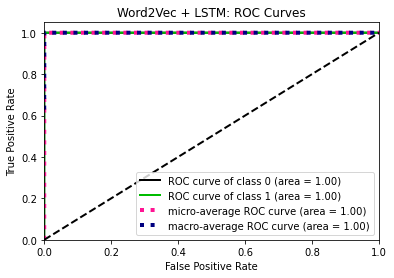

In [305]:
# Word2Vec + LSTM
lstm_pred_proba_2D = list(zip(1-lstm_pred_proba.reshape(-1), lstm_pred_proba.reshape(-1)))
plot_roc(y_test, lstm_pred_proba_2D, title='Word2Vec + LSTM: ROC Curves')
plt.show()

In [23]:
# # LSTM
# lstm_pred_proba_2D = list(zip(1-lstm_pred_proba.reshape(-1), lstm_pred_proba.reshape(-1)))
# plot_roc(y_test, lstm_pred_proba_2D, title='LSTM: ROC Curves')
# plt.show()

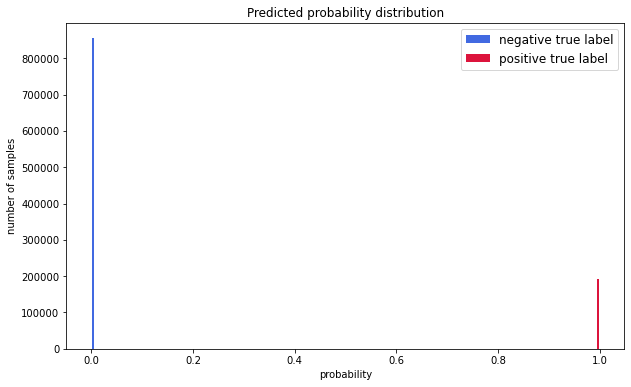

In [219]:
plt.figure(figsize=(10, 6))
plt.hist([lstm_pred_proba.reshape(-1)[y_test==0], lstm_pred_proba.reshape(-1)[y_test==1]], 
         color=['royalblue', 'crimson'], label=['negative true label', 'positive true label'], bins=100)
plt.title('Predicted probability distribution')
plt.xlabel('probability')
plt.ylabel('number of samples')
plt.legend(prop={'size': 12})
plt.show()

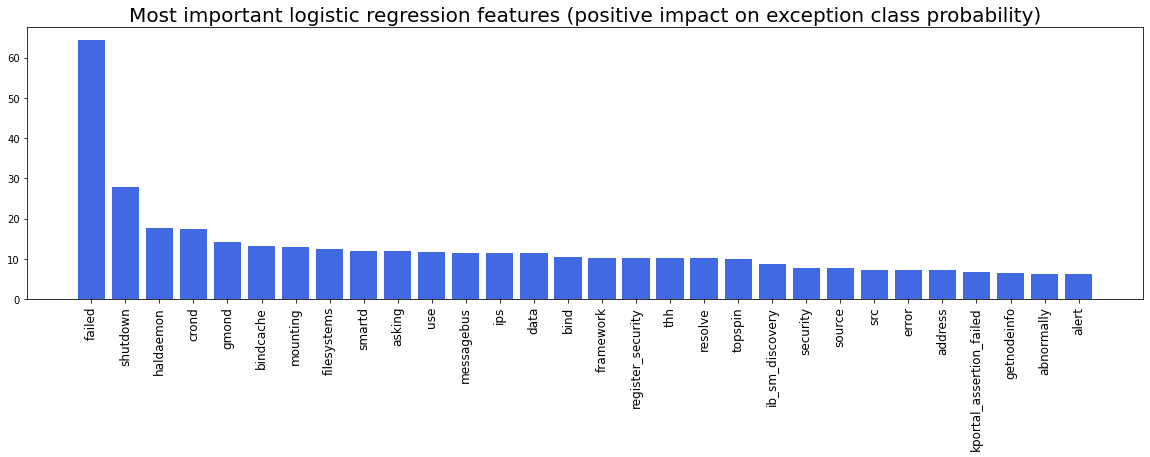

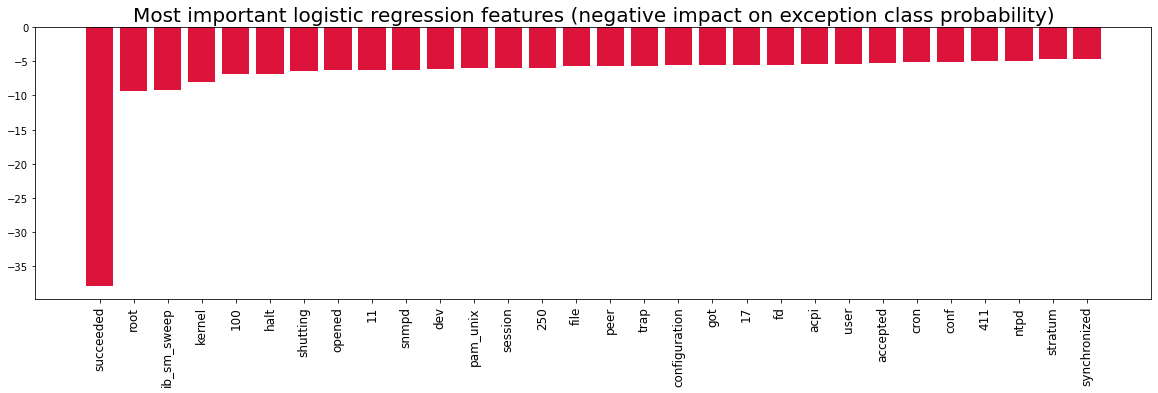

In [264]:
tfidf_importances = list(zip(tfidf.get_feature_names_out(), models_d['LogisticRegression'].coef_[0]))
tfidf_importances_sorted = sorted(tfidf_importances, key=lambda x: x[1], reverse=True)
tfidf_importances_desorted = sorted(tfidf_importances, key=lambda x: x[1])

plt.figure(figsize=(20, 5))
plt.bar([x[0] for x in tfidf_importances_sorted[:30]], [x[1] for x in tfidf_importances_sorted[:30]], 
        color='royalblue')
plt.title('Most important logistic regression features (positive impact on exception class probability)', size=20)
plt.xticks(rotation=90, fontsize=12)
plt.show()

plt.figure(figsize=(20, 5))
plt.bar([x[0] for x in tfidf_importances_desorted[:30]], [x[1] for x in tfidf_importances_desorted[:30]], 
        color='crimson')
plt.title('Most important logistic regression features (negative impact on exception class probability)', size=20)
plt.xticks(rotation=90, fontsize=12)
plt.show()